In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
cmap = 'bwr'

from PIL import Image

In [2]:
import h5py

[Group]   entry0
[Group]   entry0/D22
[Group]   entry0/D22/Distance
[Dataset] entry0/D22/Distance/det1_actual -> shape: (1,)
[Dataset] entry0/D22/Distance/det1_calc -> shape: (1,)
[Dataset] entry0/D22/Distance/det2_actual -> shape: (1,)
[Dataset] entry0/D22/Distance/det2_calc -> shape: (1,)
[Group]   entry0/D22/attenuator
[Dataset] entry0/D22/attenuator/attenuation -> shape: (1,)
[Dataset] entry0/D22/attenuator/position -> shape: (1,)
[Group]   entry0/D22/collimation
[Dataset] entry0/D22/collimation/actual_position -> shape: (1,)
[Dataset] entry0/D22/collimation/ap_size -> shape: (2,)
[Group]   entry0/D22/detector
[Dataset] entry0/D22/detector/det1_actual -> shape: (1,)
[Dataset] entry0/D22/detector/det1_calc -> shape: (1,)
[Dataset] entry0/D22/detector/det2_actual -> shape: (1,)
[Dataset] entry0/D22/detector/det2_calc -> shape: (1,)
[Group]   entry0/D22/selector
[Dataset] entry0/D22/selector/wavelength -> shape: (1,)
[Dataset] entry0/D22/selector/wavelength_res -> shape: (1,)
[Group] 

/tmp/ipykernel_3209793/547073365.py:65: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(qx, qy, I_diff, shading='auto', cmap=cmap, vmin=-2, vmax=2)


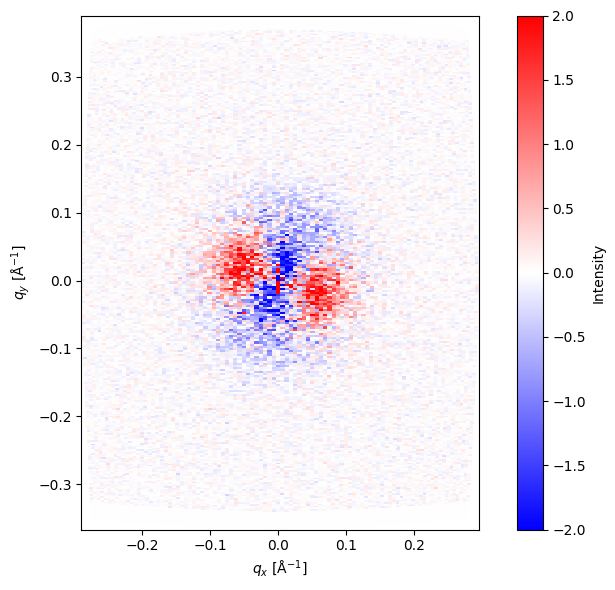

In [3]:
filename = "./data/ILL_shear/000010.nxs" 
with h5py.File(filename, 'r') as f:
    # Explore the structure
    def print_tree(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"[Dataset] {name} -> shape: {obj.shape}")
        else:
            print(f"[Group]   {name}")
    f.visititems(print_tree)
    sample_desc = f['/entry0/sample_description'][()]
    print("Sample description:", sample_desc[0].decode('utf-8'))

I_data_list = []
I_error_list = []

filename = "./data/ILL_shear/000300.nxs" 
with h5py.File(filename, 'r') as f:
    # Define dataset paths
    # path_data = '/entry0/data1/MultiDetector1_data'
    # path_error = '/entry0/data1/error1'
    # path_qx = '/entry0/data1/qx1'
    # path_qy = '/entry0/data1/qy1'
    
    path_data = '/entry0/data2/MultiDetector2_data'
    path_error = '/entry0/data2/error2'
    path_qx = '/entry0/data2/qx2'
    path_qy = '/entry0/data2/qy2'

    # Load and squeeze to remove singleton dimension
    I_data = np.squeeze(f[path_data][()])
    I_error = np.squeeze(f[path_error][()])
    qx = np.squeeze(f[path_qx][()])
    qy = np.squeeze(f[path_qy][()])
    I_data_list.append(I_data)
    I_error_list.append(I_error)

filename = "./data/ILL_shear/000305.nxs"     
with h5py.File(filename, 'r') as f:
    # Define dataset paths
    # path_data = '/entry0/data1/MultiDetector1_data'
    # path_error = '/entry0/data1/error1'
    # path_qx = '/entry0/data1/qx1'
    # path_qy = '/entry0/data1/qy1'
    
    path_data = '/entry0/data2/MultiDetector2_data'
    path_error = '/entry0/data2/error2'
    path_qx = '/entry0/data2/qx2'
    path_qy = '/entry0/data2/qy2'

    # Load and squeeze to remove singleton dimension
    I_data = np.squeeze(f[path_data][()])
    I_error = np.squeeze(f[path_error][()])
    qx = np.squeeze(f[path_qx][()])
    qy = np.squeeze(f[path_qy][()])
    I_data_list.append(I_data)
    I_error_list.append(I_error)
    
# Mask invalid intensity values (e.g., zeros or negatives)
I_diff = I_data_list[1] - I_data_list[0]
I_diff_err = np.sqrt(I_error_list[0]**2 + I_error_list[1]**2)

# Plot using object-oriented API
fig, ax = plt.subplots(figsize=(8, 6))

c = ax.pcolormesh(qx, qy, I_diff, shading='auto', cmap=cmap, vmin=-2, vmax=2)
# c2 = ax.pcolormesh(-qx, -qy, I_diff, shading='auto', cmap='viridis')
fig.colorbar(c, ax=ax, label='Intensity')

ax.set_xlabel(r'$q_x$ [$\mathrm{\AA}^{-1}$]')
ax.set_ylabel(r'$q_y$ [$\mathrm{\AA}^{-1}$]')
# ax.set_title('Scattering Intensity Map')
ax.set_aspect('equal')  # optional: square axes
plt.tight_layout()
plt.show()


In [4]:
np.max(I_diff)

70.95461495800737

In [5]:
## Identification of principal axis 
def f_pl_obs(qx_obs, qy_obs, I_obs):
    qxqx = np.sum(I_obs * qx_obs * qx_obs)
    qxqy = np.sum(I_obs * qx_obs * qy_obs)
    qyqy = np.sum(I_obs * qy_obs * qy_obs)
    R = [[qxqx, qxqy], [qxqy, qyqy]]
    eigenvalues, eigenvectors = np.linalg.eig(R)
    principal_axis = eigenvectors[:, np.argmax(eigenvalues)]
    pl_eigen = np.arctan2(principal_axis[1], principal_axis[0])
    return pl_eigen

def f_C(theta, n, theta_0=0, bg=True):
    """
    Construct a symmetric cosine basis matrix evaluated at given angles.

    Parameters:
    - theta: array-like, angles where basis is evaluated (in radians)
    - n: number of non-constant cosine modes (n > 0)
    - theta_0: alignment angle for symmetry shift
    - bg: if True, include constant (isotropic) term in first column

    Returns:
    - C: (len(theta), n+1) array if bg=True, else (len(theta), n) array
    """
    theta = np.asarray(theta)
    theta_shift = theta - theta_0
    # n_list = 2 * (np.arange(n) + 1)  # modes: 2, 4, ..., 2n
    
    # Generate candidate p values: 1, 2, 3, 4, ..., and filter
    from sympy import isprime
    p_list = [p for p in range(1, 100) if p == 1 or isprime(p)]
    # Take the first `n` values
    p_list = p_list[:n]
    # Now generate n_list = 2 * p
    n_list = 2 * np.array(p_list)

    C_cos = np.cos(np.outer(theta_shift, n_list))  # shape (M, n)

    if bg:
        C_0 = np.ones((len(theta), 1))  # constant term
        C = np.concatenate([C_0, C_cos], axis=1)  # (M, n+1)
    else:
        C = C_cos  # (M, n)

    return C

def f_CS(theta, n, theta_0=0, bg=True):
    """
    Construct a real-valued Fourier basis with symmetric cosine and sine terms.

    Parameters:
    - theta: array-like, input angles in radians
    - n: number of cosine/sine harmonics (positive integers)
    - theta_0: alignment angle (shifts all basis functions)
    - bg: if True, include constant term as first column

    Returns:
    - C: (len(theta), 2n+1) if bg=True, else (len(theta), 2n)
         Columns ordered as [1, cos(2θ), ..., cos(2nθ), sin(2θ), ..., sin(2nθ)]
    """
    theta = np.asarray(theta)
    theta_shift = theta - theta_0
    # n_list = 2 * (np.arange(1, n + 1))  # modes: 2, 4, ..., 2n
    
    # Generate candidate p values: 1, 2, 3, 4, ..., and filter
    from sympy import isprime
    p_list = [p for p in range(1, 100) if p == 1 or isprime(p)]
    # Take the first `n` values
    p_list = p_list[:n]
    # Now generate n_list = 2 * p
    n_list = 2 * np.array(p_list)

    C_cos = np.cos(np.outer(theta_shift, n_list))  # (M, n)
    C_sin = np.sin(np.outer(theta_shift, n_list))  # (M, n)

    if bg:
        C_0 = np.ones((len(theta), 1))
        C = np.concatenate([C_0, C_cos, C_sin], axis=1)  # (M, 2n+1)
    else:
        C = np.concatenate([C_cos, C_sin], axis=1)       # (M, 2n)

    return C

def f_loglin(x, x_c=1):
    return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))
def f_loglin_inv(y, y_c=0):
    return np.where(y < y_c, (1+y-y_c)*np.exp(y_c), np.exp(y))

def bayesian_inference_ratio(I_obs, delta_I_obs, Q_obs, theta_obs, delta_Q, Q_eval, C_basis, mu_, lambda_,
                              mode="forward", log_transform=False, sine_basis = False):
    """
    Perform Bayesian inference on the modulation I(Q, theta) / I_radial(Q).

    Parameters:
    - log_transform: if True, calculate the radial average on log I

    Returns:
    - A_MAP: MAP estimate of the harmonic coefficients (L x N)
    - I_radial_eval: estimated radial profile I_radial(Q_eval)
    """
    L = len(Q_eval)
    M = len(Q_obs)
    N = C_basis.shape[1]

    print(f"L (Q_eval): {L}, M (obs): {M}, N (basis): {N}")
    
    if log_transform:
        x_c = np.mean(I_obs)
        y_c = np.log(x_c)

        f_I = lambda I: f_loglin(I, x_c)
        f_inv_I = lambda fI: f_loglin_inv(fI, y_c)

        # --- Radial background estimation in transformed space ---
        fI_obs = f_I(I_obs)
        K_Qobs_to_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qeval_from_Qobs = K_Qobs_to_Qeval / K_Qobs_to_Qeval.sum(axis=0, keepdims=True)
        fI_radial_eval = W_Qeval_from_Qobs.T @ fI_obs  # shape (L,)
        I_radial_eval = f_inv_I(fI_radial_eval)

        # --- Project radial profile back to observations ---
        K_Qobs_from_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qobs_from_Qeval = K_Qobs_from_Qeval / K_Qobs_from_Qeval.sum(axis=1, keepdims=True)
        fI_radial_obs = W_Qobs_from_Qeval @ fI_radial_eval  # shape (M,)
        I_radial_obs = f_inv_I(fI_radial_obs)
    else:
        # --- Radial background estimation ---
        K_Qobs_to_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qeval_from_Qobs = K_Qobs_to_Qeval / K_Qobs_to_Qeval.sum(axis=0, keepdims=True)
        I_radial_eval = W_Qeval_from_Qobs.T @ I_obs  # shape (L,)

        # --- Project radial profile back to observations ---
        K_Qobs_from_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qobs_from_Qeval = K_Qobs_from_Qeval / K_Qobs_from_Qeval.sum(axis=1, keepdims=True)
        I_radial_obs = W_Qobs_from_Qeval @ I_radial_eval  # shape (M,)
    

    # --- Normalize observations ---
    I_mod = I_obs / I_radial_obs
    delta_I_mod = delta_I_obs / I_radial_obs

    # --- Construct design matrix (M x LN) ---
    G = (K_Qobs_to_Qeval[:, :, None] * C_basis[:, None, :]).reshape(M, L * N)

    # --- Prior covariance ---
    Q_diff_sq = (Q_eval[:, None] - Q_eval[None, :]) ** 2
    K_spatial = np.exp(-Q_diff_sq / (2 * lambda_ ** 2))
    K_spatial_full = np.kron(np.eye(N), K_spatial)

    from sympy import isprime
    p_list = [p for p in range(1, 100) if p == 1 or isprime(p)]
    # Take the first `n` values
    p_list = p_list[:N-1]
    if sine_basis:
        p_list = [p for p in range(1, 100) if p == 1 or isprime(p)]
        p_list = p_list[:(N-1)//2]
        p_list = [val for p in p_list for val in (p, p)]
    # Now generate n_list = 2 * p
    angular_penalty = np.array([0] + [(2*n) for n in p_list])
    
    # angular_penalty = np.array([0] + [(2*n) for n in range(1, N)])
    K_angular = np.kron(np.diag(angular_penalty), np.eye(L))
    K_prior = K_spatial_full + K_angular

    # --- Prior mean ---
    A_prior_mean = np.zeros((L, N))
    A_prior_mean[:, 0] = 1.0 
    A_prior_flat = A_prior_mean.flatten()

    # --- Observation noise covariance ---
    Sigma = np.diag(delta_I_mod**2)

    # --- MAP Inference ---
    if mode == "forward":
        Sigma_inv = np.diag(1.0 / delta_I_mod**2)
        GT_Sinv = G.T @ Sigma_inv
        K_tilde_inv = GT_Sinv @ G + np.linalg.inv(K_prior) 
        K_tilde_inv = K_tilde_inv + 1e-6 * np.eye(K_tilde_inv.shape[0])
        rhs = GT_Sinv @ (I_mod - G @ A_prior_flat)
        # A_post_flat = A_prior_flat + cho_solve(cho_factor(K_tilde_inv), rhs)
        try:
            A_post_flat = A_prior_flat + cho_solve(cho_factor(K_tilde_inv), rhs)
        except np.linalg.LinAlgError:
            print("Cholesky failed, falling back to np.linalg.solve")
            A_post_flat = A_prior_flat + np.linalg.solve(K_tilde_inv, rhs)
        
    elif mode == "dual":
        residual = I_mod - G @ A_prior_flat
        G_K = G @ K_prior
        K_tilde = G_K @ G.T + Sigma
        A_post_flat = A_prior_flat + K_prior @ G.T @ cho_solve(cho_factor(K_tilde), residual)
    else:
        raise ValueError("mode must be 'forward' or 'dual'")

    A_MAP = A_post_flat.reshape(L, N)
    return A_MAP, I_radial_eval

def reconstruct_I_q(Q_eval, theta_eval, A_MAP, f_basis, mu_, theta_0=0.0,
                    direct=False, bg=True, I_radial_eval=None, log_transform=False, sine_basis = False):
    """
    Reconstruct the intensity modulation I(Q, theta)/I_radial(Q) or log-form.

    Parameters:
    - log_transform: If True, A_MAP represents log(I / I_radial)

    Returns:
    - I_modulated: shape (K, L), modulation (I / I_radial) or exp(log modulation)
    """
    L, N = A_MAP.shape
    K = len(theta_eval)

    # Angular basis matrix (K, N)
    C_arr = f_basis(theta_eval, N - 1 if bg else N, theta_0=theta_0, bg=bg)
    if sine_basis:
        C_arr = f_CS(theta_eval, (N - 1)//2 if bg else N//2, theta_0=theta_0, bg=bg)

    if direct:
        I_modulated = C_arr @ A_MAP.T  # (K, L)
    else:
        spatial_kernel_eval = np.exp(-((Q_eval[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))  # (L, L)
        I_modulated = (spatial_kernel_eval @ A_MAP) @ C_arr.T  # (L, K)
        I_modulated = I_modulated.T  # shape (K, L)

    # Restore full I(Q, theta) if bg was removed
    if not bg:
        if I_radial_eval is None:
            raise ValueError("Must provide I_radial_eval if bg=False")
        I_modulated *= I_radial_eval[None, :]  # elementwise multiply

    return I_modulated

def reconstruct_I_q_ratio(Q_eval, theta_eval, A_MAP, f_basis, mu_, I_radial_eval,
                          theta_0=0.0, direct=False, log_transform=False, sine_basis = False):
    """
    Reconstruct full I(Q, theta) from inferred modulation coefficients and radial profile.

    Parameters:
    - log_transform: If True, treat A_MAP as log(I/I_radial)

    Returns:
    - I_full: (K, L) reconstructed intensity I(Q, theta)
    - I_mod:  (K, L) modulation (I/I_radial) or exp(log modulation)
    """
    I_mod = reconstruct_I_q(
        Q_eval, theta_eval, A_MAP, f_basis, mu_,
        theta_0=theta_0, direct=direct, bg=True,
        I_radial_eval=None, log_transform=log_transform, sine_basis = sine_basis
    )

    I_full = I_mod * I_radial_eval[None, :]  # restore I(Q, theta)
    return I_full, I_mod


In [6]:
qx_flat = qx.flatten()
qy_flat = qy.flatten()
I_diff_flat = I_diff.flatten()
I_diff_err_flat = I_diff_err.flatten()

Q_obs_all = np.sqrt(qx_flat**2 + qy_flat**2)
theta_obs_all = np.arctan2(qy_flat, qx_flat)
# Apply full mask as boolean condition
valid = (Q_obs_all > 0.001) & (Q_obs_all < 0.3)

# Final filtered arrays (force regular ndarray)
Q_obs = np.asarray(Q_obs_all[valid])
theta_obs = np.asarray(theta_obs_all[valid])
I_obs = np.asarray(I_diff_flat[valid])
delta_I_obs = np.asarray(I_diff_err_flat[valid])

# Q for evaluation
Q_eval = np.linspace(0.001, np.max(qx), 100)  # Define Q_eval range
theta_eval = np.linspace(-np.pi, np.pi, 360, endpoint=False)
# pl_eigen = np.pi/2  # Convert to radians
pl_eigen = f_pl_obs(Q_obs * np.cos(theta_obs), Q_obs * np.sin(theta_obs), I_obs)

# --- Step 3: Angular basis setup (include constant term for I/I_radial) ---
n = 15
bg = True  # Must include constant term
C_arr = f_C(theta_obs, n, theta_0=pl_eigen, bg=bg)

# --- Step 4: Inference parameters ---
lambda_ = 0.03
mu_ = 0.03
delta_Q = Q_eval[1] - Q_eval[0]
log_transform = False  # <--- Enable log-transformed inference
eps = 1e-8  # small positive number to prevent log(0) 

# --- Step 5: Perform inference on log(I/I_radial) or I/I_radial ---
A_MAP, I_radial_eval = bayesian_inference_ratio(
    I_obs, delta_I_obs, Q_obs, theta_obs,
    delta_Q, Q_eval, C_arr, mu_, lambda_,
    mode="forward",
    log_transform=log_transform
)
print(A_MAP.shape)

# --- Step 7: Reconstruct I(q, theta) ---
I_eval, I_mod = reconstruct_I_q_ratio(
    Q_eval, theta_eval, A_MAP, f_C, mu_,
    I_radial_eval, theta_0=pl_eigen, direct=False,
    log_transform=log_transform
)

L (Q_eval): 100, M (obs): 15211, N (basis): 16
Cholesky failed, falling back to np.linalg.solve
(100, 16)


In [7]:
# Inferred results ---------------------------------------------------------------
# Total number of pixels (needed for normalization)
# Evaluate grids and flat
Q_eval_grid, theta_eval_grid = np.meshgrid(Q_eval, theta_eval)
Qx_eval = Q_eval_grid * np.cos(theta_eval_grid)
Qy_eval = Q_eval_grid * np.sin(theta_eval_grid)

# flat
I_eval_flat = I_eval.flatten()

# Compute radial backgrounds
I_eval_radial = np.mean(I_eval, axis=0)[None, :]
I_eval_radial_flat = np.tile(I_eval_radial, (len(theta_eval), 1)).flatten()

# Shuffle indices
index_shuffle = np.arange(I_eval_flat.size)
np.random.shuffle(index_shuffle)

# Apply shuffle to everything
theta_eval_flat = theta_eval_grid.flatten()[index_shuffle]
Q_eval_flat = Q_eval_grid.flatten()[index_shuffle]
Qx_eval_flat = Qx_eval.flatten()[index_shuffle]
Qy_eval_flat = Qy_eval.flatten()[index_shuffle]
I_eval_flat = I_eval_flat[index_shuffle]
I_eval_radial_flat = I_eval_radial_flat[index_shuffle]

/tmp/ipykernel_3209793/3450221994.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(qx, qy, I_diff, shading='auto', cmap=cmap, vmin=-4, vmax=4)


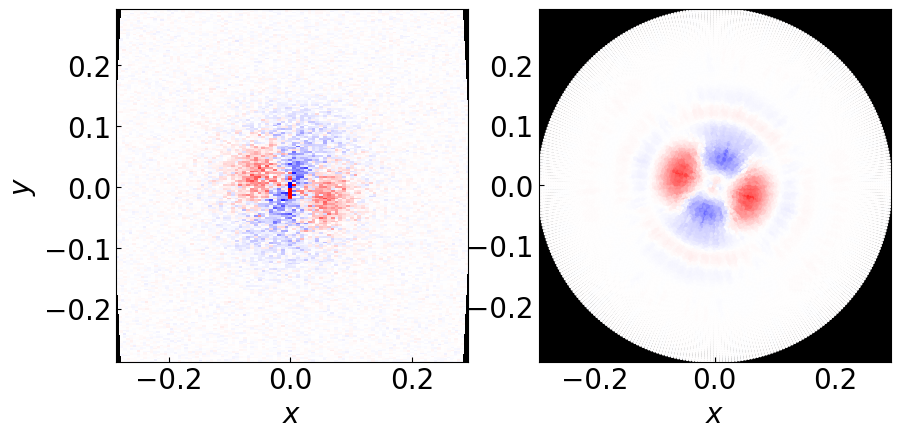

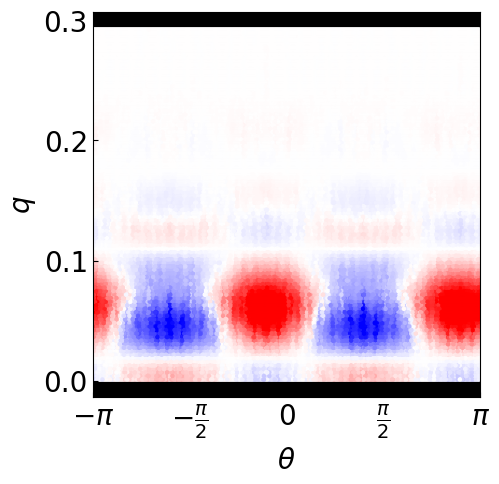

In [8]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(122)
sc = ax.scatter(Qx_eval_flat, Qy_eval_flat, c=I_eval_flat,
                s=2, alpha=1, cmap=cmap, vmin = -4, vmax = 4)
ax.set_xlabel(r'$x$', fontsize=20)
ax.set_ylabel(r'$y$', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.set_xlim(np.min(Qx_eval_flat), np.max(Qx_eval_flat))
ax.set_ylim(np.min(Qx_eval_flat), np.max(Qx_eval_flat))
ax.set_aspect(1)
ax.set_facecolor('black')

ax = fig.add_subplot(121)

c = ax.pcolormesh(qx, qy, I_diff, shading='auto', cmap=cmap, vmin=-4, vmax=4)
# c2 = ax.pcolormesh(-qx, -qy, I_diff, shading='auto', cmap='viridis')
# fig.colorbar(c, ax=ax, label='Intensity')

ax.set_xlabel(r'$q_x$ [$\mathrm{\AA}^{-1}$]')
ax.set_ylabel(r'$q_y$ [$\mathrm{\AA}^{-1}$]')
# ax.set_title('Scattering Intensity Map')
ax.set_facecolor('black')

ax.set_xlabel(r'$x$', fontsize=20)
ax.set_ylabel(r'$y$', fontsize=20)
ax.tick_params(direction='in', labelsize=20)

ax.set_xlim(np.min(qx), np.max(qx))
ax.set_ylim(np.min(qx), np.max(qx))
ax.set_aspect(1)
ax.set_facecolor('black')

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
sc = ax.scatter(theta_eval_flat, Q_eval_flat, c=I_eval_flat,
                s=5, alpha=1, cmap=cmap, vmin = -2, vmax = 2)
ax.set_xlabel(r'$\theta$', fontsize=20)
ax.set_ylabel(r'$q$', fontsize=20)
ax.set(xlim=(-np.pi, np.pi), 
       xticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
       xticklabels=[r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'],
       xlabel=r'$\theta$', ylabel=r'$q$')
ax.set_xlabel(r'$\theta$', fontsize=20)
ax.set_ylabel(r'$q$', fontsize=20)
ax.tick_params(direction='in', labelsize=20)
ax.set_facecolor('black')

Sample description: TREATED: HQ CTAB at pos= 141.18 at rest 
L (Q_eval): 80, M (obs): 15195, N (basis): 23


/tmp/ipykernel_3209793/2519885331.py:53: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(qx, qy, I_diff, shading='auto', cmap=cmap, vmin=-5, vmax=5)


Cholesky failed, falling back to np.linalg.solve
(80, 23)
Sample description: TREATED: HQ CTAB at pos= 141.36 at rest 
L (Q_eval): 80, M (obs): 15195, N (basis): 17
Cholesky failed, falling back to np.linalg.solve
(80, 17)
Sample description: TREATED: HQ CTAB at pos= 141.54 at rest 
L (Q_eval): 80, M (obs): 15195, N (basis): 11
Cholesky failed, falling back to np.linalg.solve
(80, 11)


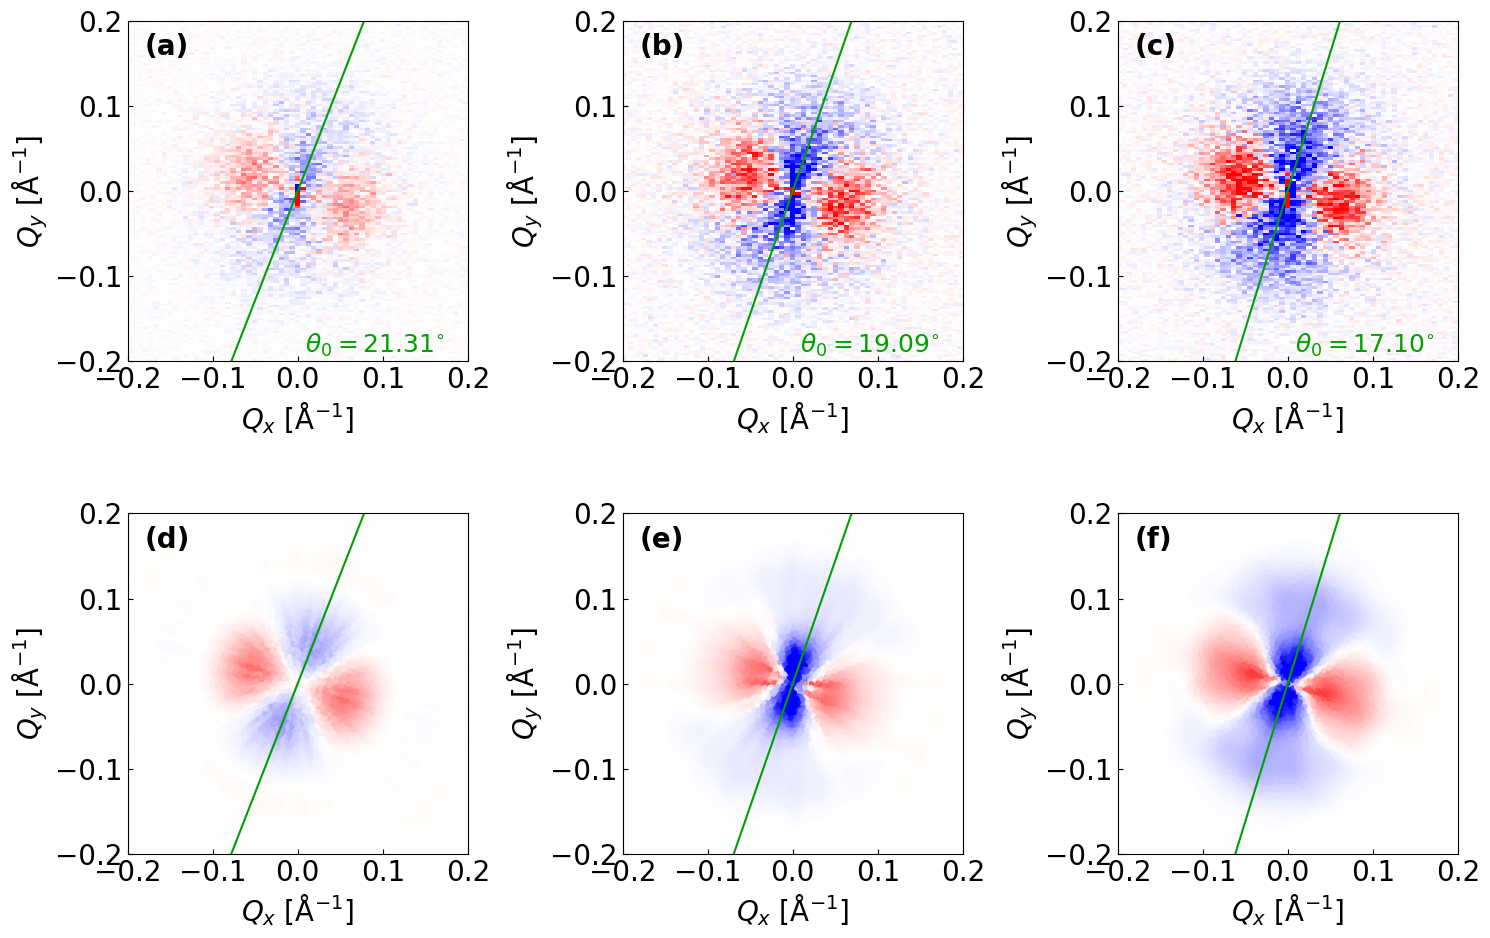

In [38]:
## load data series
data_list = []
position_list = [3,4,5]
n_list = [11,8,5]
lambda_list = [0.045, 0.045, 0.03]

panels_list = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]

fig = plt.figure(figsize=(15, 10))
for index, position in enumerate(position_list):
    filename = f"./data/ILL_shear/000{position}00.nxs" 
    
    I_data_list = []
    I_error_list = []
    with h5py.File(filename, 'r') as f:        
        path_data = '/entry0/data2/MultiDetector2_data'
        path_error = '/entry0/data2/error2'
        path_qx = '/entry0/data2/qx2'
        path_qy = '/entry0/data2/qy2'

        # Load and squeeze to remove singleton dimension
        I_data = np.squeeze(f[path_data][()])
        I_error = np.squeeze(f[path_error][()])
        qx = np.squeeze(f[path_qx][()])
        qy = np.squeeze(f[path_qy][()])
        I_data_list.append(I_data)
        I_error_list.append(I_error)
        sample_desc = f['/entry0/sample_description'][()]
        print("Sample description:", sample_desc[0].decode('utf-8'))
        
    filename = f"./data/ILL_shear/000{position}05.nxs"
    with h5py.File(filename, 'r') as f:
        path_data = '/entry0/data2/MultiDetector2_data'
        path_error = '/entry0/data2/error2'
        path_qx = '/entry0/data2/qx2'
        path_qy = '/entry0/data2/qy2'

        # Load and squeeze to remove singleton dimension
        I_data = np.squeeze(f[path_data][()])
        I_error = np.squeeze(f[path_error][()])
        qx = np.squeeze(f[path_qx][()])
        qy = np.squeeze(f[path_qy][()])
        I_data_list.append(I_data)
        I_error_list.append(I_error)
        
    I_diff = I_data_list[1] - I_data_list[0]
    I_diff_err = np.sqrt(I_error_list[0]**2 + I_error_list[1]**2)
    data_list.append((I_diff, I_diff_err, qx, qy))
    
    # Plot using object-oriented API
    ax = fig.add_subplot(2,3,index+1)

    c = ax.pcolormesh(qx, qy, I_diff, shading='auto', cmap=cmap, vmin=-5, vmax=5)
    # c2 = ax.pcolormesh(-qx, -qy, I_diff, shading='auto', cmap='viridis')
    # fig.colorbar(c, ax=ax, label='Intensity')

    # ax.set_title('Scattering Intensity Map')
    ax.set_facecolor('black')

    ax.set_xlabel(r'$Q_x$ [$\mathrm{\AA}^{-1}$]', fontsize=20)
    ax.set_ylabel(r'$Q_y$ [$\mathrm{\AA}^{-1}$]', fontsize=20)
    ax.set_xticks([-0.2, -0.1, 0, 0.1, 0.2])
    ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
    ax.tick_params(direction='in', labelsize=20)
    # Plot a line aligned with pl_eigen
    ax.text(0.05, 0.9, panels_list[index], color='k', fontsize=20, fontweight='bold', transform=ax.transAxes)

    # ax.set_xlim(np.min(qx)*1.05, np.max(qx)*1.05)
    # ax.set_ylim(np.min(qx)*1.05, np.max(qx)*1.05)
    ax.set_xlim(-0.2, 0.2)
    ax.set_ylim(-0.2, 0.2)
    ax.set_aspect(1)
    ax.set_facecolor('black')
    
    # GPR ---------------------------------------------------------------
    qx_flat = qx.flatten()
    qy_flat = qy.flatten()
    I_diff_flat = I_diff.flatten()
    I_diff_err_flat = I_diff_err.flatten()

    Q_obs_all = np.sqrt(qx_flat**2 + qy_flat**2)
    theta_obs_all = np.arctan2(qy_flat, qx_flat)
    # Apply full mask as boolean condition
    valid = (Q_obs_all > 0.01) & (Q_obs_all < 0.3)

    # Final filtered arrays (force regular ndarray)
    Q_obs = np.asarray(Q_obs_all[valid])
    theta_obs = np.asarray(theta_obs_all[valid])
    I_obs = np.asarray(I_diff_flat[valid])
    delta_I_obs = np.asarray(I_diff_err_flat[valid])
    I_sheared_obs = np.asarray(I_data_list[1].flatten()[valid])
    pl_eigen = f_pl_obs(Q_obs * np.cos(theta_obs), Q_obs * np.sin(theta_obs), I_sheared_obs)
    q_max = np.max(np.abs([np.min(qx), np.max(qx), np.min(qy), np.max(qy)]))
    x_line = np.array([-q_max, q_max])
    y_line = np.tan(pl_eigen+np.pi/2) * x_line
    ax.plot(x_line, y_line, color='#00A000', linestyle='-', linewidth=1.5, label='pl eigen')
    ax.text(0.52, 0.025, r"$\theta_0 = {:.2f}^{{\circ}}$".format(-np.degrees(pl_eigen)), color='#00A000', fontsize=18, fontweight='bold', transform=ax.transAxes)

    # Q for evaluation
    Q_eval = np.linspace(0, np.max(qx), 80)  # Define Q_eval range
    theta_eval = np.linspace(-np.pi, np.pi, 360, endpoint=False)
    # pl_eigen = np.pi/2  # Convert to radians

    # --- Step 3: Angular basis setup (include constant term for I/I_radial) ---
    n = n_list[index]
    bg = True  # Must include constant term
    C_arr = f_CS(theta_obs, n, theta_0=pl_eigen, bg=bg)

    # --- Step 4: Inference parameters ---
    lambda_ = lambda_list[index]
    mu_ = lambda_
    delta_Q = Q_eval[1] - Q_eval[0]
    log_transform = False  # <--- Enable log-transformed inference
    eps = 1e-8  # small positive number to prevent log(0) 

    # --- Step 5: Perform inference on log(I/I_radial) or I/I_radial ---
    A_MAP, I_radial_eval = bayesian_inference_ratio(
        I_obs, delta_I_obs, Q_obs, theta_obs,
        delta_Q, Q_eval, C_arr, mu_, lambda_,
        mode="forward",
        log_transform=log_transform, sine_basis = True
    )
    print(A_MAP.shape)

    # --- Step 7: Reconstruct I(q, theta) ---
    I_eval, I_mod = reconstruct_I_q_ratio(
        Q_eval, theta_eval, A_MAP, f_CS, mu_,
        I_radial_eval, theta_0=pl_eigen, direct=False,
        log_transform=log_transform, sine_basis = True
    )
    
    # Inferred results ---------------------------------------------------------------
    # Total number of pixels (needed for normalization)
    # Evaluate grids and flat
    Q_eval_grid, theta_eval_grid = np.meshgrid(Q_eval, theta_eval)
    Qx_eval = Q_eval_grid * np.cos(theta_eval_grid)
    Qy_eval = Q_eval_grid * np.sin(theta_eval_grid)

    # flat
    I_eval_flat = I_eval.flatten()

    # Compute radial backgrounds
    I_eval_radial = np.mean(I_eval, axis=0)[None, :]
    I_eval_radial_flat = np.tile(I_eval_radial, (len(theta_eval), 1)).flatten()

    # Shuffle indices
    index_shuffle = np.arange(I_eval_flat.size)
    np.random.shuffle(index_shuffle)

    # Apply shuffle to everything
    theta_eval_flat = theta_eval_grid.flatten()[index_shuffle]
    Q_eval_flat = Q_eval_grid.flatten()[index_shuffle]
    Qx_eval_flat = Qx_eval.flatten()[index_shuffle]
    Qy_eval_flat = Qy_eval.flatten()[index_shuffle]
    I_eval_flat = I_eval_flat[index_shuffle]
    I_eval_radial_flat = I_eval_radial_flat[index_shuffle]
        
    ax = fig.add_subplot(2,3,index+4)
    sc = ax.scatter(Qx_eval_flat, Qy_eval_flat, c=I_eval_flat,
                    s=8, alpha=0.75, cmap=cmap, vmin = -5, vmax = 5)
    ax.plot(x_line, y_line, color='#00A000', linestyle='-', linewidth=1.5, label='pl eigen')
    ax.set_xlabel(r'$Q_x$ [$\mathrm{\AA}^{-1}$]', fontsize=20)
    ax.set_ylabel(r'$Q_y$ [$\mathrm{\AA}^{-1}$]', fontsize=20)
    ax.set_xticks([-0.2, -0.1, 0, 0.1, 0.2])
    ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
    ax.tick_params(direction='in', labelsize=20)

    # ax.set_xlim(np.min(qx)*1.05, np.max(qx)*1.05)
    # ax.set_ylim(np.min(qx)*1.05, np.max(qx)*1.05)
    ax.set_xlim(-0.2, 0.2)
    ax.set_ylim(-0.2, 0.2)
    ax.set_aspect(1)
    
    ax.set_facecolor('w')
    ax.text(0.05, 0.9, panels_list[index+3], color='k', fontsize=20, fontweight='bold', transform=ax.transAxes)
    # ax.text(0.602, 0.022, r"$\theta_0 = {:.2f}^{{\circ}}$".format(np.degrees(pl_eigen)), color='k', fontsize=15, fontweight='bold', transform=ax.transAxes)

plt.tight_layout()

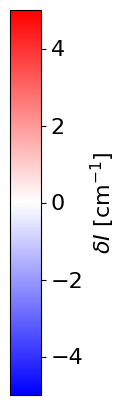

In [39]:
# Create a vertical colorbar according to the time list in viridis colormap
fig, ax = plt.subplots(figsize=(0.4, 5))
norm = plt.Normalize(vmin=-5, vmax=5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=ax)
cbar.set_label(r'$\delta I\ [\mathrm{cm}^{-1}]$', fontsize=16)
cbar.ax.tick_params(labelsize=16)